In [2]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import gym
import torch.nn as nn

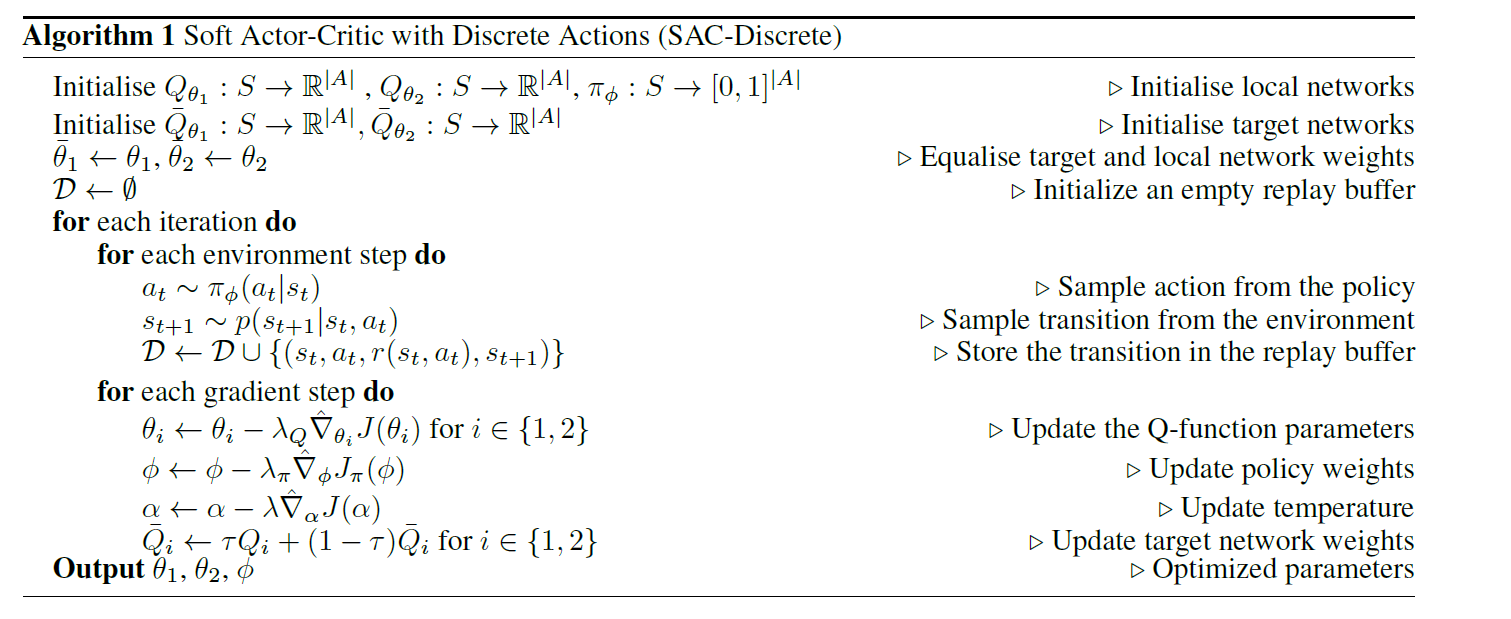

reference: https://github.com/Felhof/DiscreteSAC

Define Network

In [3]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=128)
        self.layer_2 = torch.nn.Linear(in_features=128, out_features=64)
        self.output_layer = torch.nn.Linear(in_features=64, out_features=output_dimension)
        self.output_activation = output_activation
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, inpt):
        layer_1_output = torch.nn.functional.relu(self.layer_1(inpt))
        layer_2_output = torch.nn.functional.relu(self.layer_2(layer_1_output))
        output = self.output_activation(self.output_layer(layer_2_output))
        return output

Replay Buffer

In [4]:
class ReplayBuffer:

    def __init__(self, environment, capacity=5000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

# SAC Agent

In [7]:
class SACAgent:

    ALPHA_INITIAL = 0.2  #Entropy Coeff
    REPLAY_BUFFER_BATCH_SIZE = 64
    DISCOUNT_RATE = 0.95
    LEARNING_RATE = 1e-3
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01 #Soft update factor

    def __init__(self, environment):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n
        self.critic_local = Network(input_dimension=self.state_dim,
                                    output_dimension=self.action_dim)
        self.critic_local2 = Network(input_dimension=self.state_dim,
                                     output_dimension=self.action_dim)
        self.critic_optimiser = torch.optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = torch.optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)

        self.critic_target = Network(input_dimension=self.state_dim,
                                     output_dimension=self.action_dim)
        self.critic_target2 = Network(input_dimension=self.state_dim,
                                      output_dimension=self.action_dim)

        self.soft_update_target_networks(tau=1.)

        self.actor_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim,
            output_activation=torch.nn.Softmax(dim=1)
        )
        self.actor_optimiser = torch.optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)

        self.replay_buffer = ReplayBuffer(self.environment)

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action


    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition):
        # Set all the gradients stored in the optimisers to zero.
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        # Calculate the loss for this transition.
        self.replay_buffer.add_transition(transition)
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network
        # parameters.
        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            # get minibatch of 100 transitions from replay buffer
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE)
            minibatch_separated = list(map(list, zip(*minibatch)))

            # unravel transitions to get states, actions, rewards and next states
            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            critic_loss, critic2_loss = \
                self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)

            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)

            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)

            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks()

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor):
        with torch.no_grad():
            action_probabilities, log_action_probabilities = self.get_action_info(next_states_tensor)
            next_q_values_target = self.critic_target.forward(next_states_tensor)
            next_q_values_target2 = self.critic_target2.forward(next_states_tensor)
            soft_state_values = (action_probabilities * (
                    torch.min(next_q_values_target, next_q_values_target2) - self.alpha * log_action_probabilities
            )).sum(dim=1)

            next_q_values = rewards_tensor + ~done_tensor * self.DISCOUNT_RATE*soft_state_values

        soft_q_values = self.critic_local(states_tensor).gather(1, actions_tensor.type(torch.int64).unsqueeze(-1)).squeeze(-1)
        soft_q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.type(torch.int64).unsqueeze(-1)).squeeze(-1)
        critic_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values, next_q_values)
        critic2_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values2, next_q_values)
        weight_update = [min(l1.item(), l2.item()) for l1, l2 in zip(critic_square_error, critic2_square_error)]
        self.replay_buffer.update_weights(weight_update)
        critic_loss = critic_square_error.mean()
        critic2_loss = critic2_square_error.mean()
        return critic_loss, critic2_loss

    def actor_loss(self, states_tensor,):
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        q_values_local = self.critic_local(states_tensor)
        q_values_local2 = self.critic_local2(states_tensor)
        inside_term = self.alpha * log_action_probabilities - torch.min(q_values_local, q_values_local2)
        policy_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return policy_loss, log_action_probabilities

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

# Cartpole Simulation

In [ ]:
TRAINING_EVALUATION_RATIO = 4
RUNS = 5
EPISODES_PER_RUN = 400
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")
agent_results = []
for run in range(RUNS):
    agent = SACAgent(env)
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        print('\r', f'Run: {run + 1}/{RUNS} | Episode: {episode_number + 1}/{EPISODES_PER_RUN}', end=' ')
        evaluation_episode = episode_number % TRAINING_EVALUATION_RATIO == 0
        episode_reward = 0
        state = env.reset()
        done = False
        i = 0
        while not done and i < STEPS_PER_EPISODE:
            i += 1
            action = agent.get_next_action(state, evaluation_episode=evaluation_episode)
            next_state, reward, done, info = env.step(action)
            if not evaluation_episode:
                agent.train_on_transition(state, action, next_state, reward, done)
            else:
                episode_reward += reward
            state = next_state
        if evaluation_episode:
            run_results.append(episode_reward)
    agent_results.append(run_results)

env.close()

n_results = EPISODES_PER_RUN // TRAINING_EVALUATION_RATIO
results_mean = [np.mean([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
results_std = [np.std([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
mean_plus_std = [m + s for m, s in zip(results_mean, results_std)]
mean_minus_std = [m - s for m, s in zip(results_mean, results_std)]

x_vals = list(range(len(results_mean)))
x_vals = [x_val * (TRAINING_EVALUATION_RATIO - 1) for x_val in x_vals]

ax = plt.gca()
ax.set_ylim([0, 200])
ax.set_ylabel('Episode Score')
ax.set_xlabel('Training Episode')
ax.plot(x_vals, results_mean, label='Average Result', color='blue')
ax.plot(x_vals, mean_plus_std, color='blue', alpha=0.1)
ax.plot(x_vals, mean_minus_std, color='blue', alpha=0.1)
ax.fill_between(x_vals, y1=mean_minus_std, y2=mean_plus_std, alpha=0.1, color='blue')
plt.legend(loc='best')
plt.show()

# GMM Model

In [8]:
import gym
from machine import Machine
from GymMachEnv import MachineEnv

In [14]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)
agent = SACAgent(env)

<ipython-input-2-a5cbee462eff>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [9]:
TRAINING_EVALUATION_RATIO = 5
RUNS = 1
EPISODES_PER_RUN = 10000
STEPS_PER_EPISODE = 100
log_interval = 10


machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

agent_results = []
for run in range(RUNS):
    agent = SACAgent(env)
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        print('\r', f'Run: {run + 1}/{RUNS} | Episode: {episode_number + 1}/{EPISODES_PER_RUN}', end=' ')
        
        episode_reward = 0
        state = env.reset()
        done = False
        evaluation_episode = episode_number % TRAINING_EVALUATION_RATIO == 0
        i = 0
        while not done:
            i += 1
            action = agent.get_next_action(state, evaluation_episode=evaluation_episode)
            next_state, reward, done, info = env.step(action)
            
            
            if episode_number % TRAINING_EVALUATION_RATIO == 0:
                agent.train_on_transition(state, action, next_state, reward, done)
            
            episode_reward += reward
            
            state = next_state
        print("Episode reward, ",episode_reward)
        if evaluation_episode:
            run_results.append(episode_reward)
    agent_results.append(run_results)

env.close()

# n_results = EPISODES_PER_RUN // TRAINING_EVALUATION_RATIO
# results_mean = [np.mean([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
# results_std = [np.std([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
# mean_plus_std = [m + s for m, s in zip(results_mean, results_std)]
# mean_minus_std = [m - s for m, s in zip(results_mean, results_std)]

# x_vals = list(range(len(results_mean)))
# x_vals = [x_val * (TRAINING_EVALUATION_RATIO - 1) for x_val in x_vals]

# ax = plt.gca()
# ax.set_ylim([0, 200])
# ax.set_ylabel('Episode Score')
# ax.set_xlabel('Training Episode')
# ax.plot(x_vals, results_mean, label='Average Result', color='blue')
# ax.plot(x_vals, mean_plus_std, color='blue', alpha=0.1)
# ax.plot(x_vals, mean_minus_std, color='blue', alpha=0.1)
# ax.fill_between(x_vals, y1=mean_minus_std, y2=mean_plus_std, alpha=0.1, color='blue')
# plt.legend(loc='best')
# plt.show()

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
<ipython-input-3-a5cbee462eff>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


 Run: 1/1 | Episode: 1/10000 Episode reward,  5200
 Run: 1/1 | Episode: 2/10000 Episode reward,  8300
 Run: 1/1 | Episode: 3/10000 Episode reward,  4900
 Run: 1/1 | Episode: 4/10000 Episode reward,  30000
 Run: 1/1 | Episode: 5/10000 Episode reward,  14500
 Run: 1/1 | Episode: 6/10000 Episode reward,  5800
 Run: 1/1 | Episode: 7/10000 Episode reward,  18100
 Run: 1/1 | Episode: 8/10000 Episode reward,  17500
 Run: 1/1 | Episode: 9/10000 Episode reward,  10000
 Run: 1/1 | Episode: 10/10000 Episode reward,  -2300
 Run: 1/1 | Episode: 11/10000 Episode reward,  700
 Run: 1/1 | Episode: 12/10000 Episode reward,  12400
 Run: 1/1 | Episode: 13/10000 Episode reward,  37300
 Run: 1/1 | Episode: 14/10000 Episode reward,  32100
 Run: 1/1 | Episode: 15/10000 Episode reward,  32200
 Run: 1/1 | Episode: 16/10000 Episode reward,  3500
 Run: 1/1 | Episode: 17/10000 Episode reward,  50400
 Run: 1/1 | Episode: 18/10000 Episode reward,  47300
 Run: 1/1 | Episode: 19/10000 Episode reward,  14600
 Run: 1/1

 Run: 1/1 | Episode: 157/10000 Episode reward,  12300
 Run: 1/1 | Episode: 158/10000 Episode reward,  1000
 Run: 1/1 | Episode: 159/10000 Episode reward,  7800
 Run: 1/1 | Episode: 160/10000 Episode reward,  3300
 Run: 1/1 | Episode: 161/10000 Episode reward,  4800
 Run: 1/1 | Episode: 162/10000 Episode reward,  3700
 Run: 1/1 | Episode: 163/10000 Episode reward,  4100
 Run: 1/1 | Episode: 164/10000 Episode reward,  8000
 Run: 1/1 | Episode: 165/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 166/10000 Episode reward,  8200
 Run: 1/1 | Episode: 167/10000 Episode reward,  3800
 Run: 1/1 | Episode: 168/10000 Episode reward,  12900
 Run: 1/1 | Episode: 169/10000 Episode reward,  5300
 Run: 1/1 | Episode: 170/10000 Episode reward,  8900
 Run: 1/1 | Episode: 171/10000 Episode reward,  2900
 Run: 1/1 | Episode: 172/10000 Episode reward,  3100
 Run: 1/1 | Episode: 173/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 174/10000 Episode reward,  8600
 Run: 1/1 | Episode: 175/10000 Episode rew

 Run: 1/1 | Episode: 311/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 312/10000 Episode reward,  1500
 Run: 1/1 | Episode: 313/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 314/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 315/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 316/10000 Episode reward,  11000
 Run: 1/1 | Episode: 317/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 318/10000 Episode reward,  10500
 Run: 1/1 | Episode: 319/10000 Episode reward,  500
 Run: 1/1 | Episode: 320/10000 Episode reward,  5900
 Run: 1/1 | Episode: 321/10000 Episode reward,  -300
 Run: 1/1 | Episode: 322/10000 Episode reward,  17600
 Run: 1/1 | Episode: 323/10000 Episode reward,  2200
 Run: 1/1 | Episode: 324/10000 Episode reward,  12600
 Run: 1/1 | Episode: 325/10000 Episode reward,  4300
 Run: 1/1 | Episode: 326/10000 Episode reward,  -300
 Run: 1/1 | Episode: 327/10000 Episode reward,  58400
 Run: 1/1 | Episode: 328/10000 Episode reward,  7500
 Run: 1/1 | Episode: 329/10000 Episod

 Run: 1/1 | Episode: 466/10000 Episode reward,  9500
 Run: 1/1 | Episode: 467/10000 Episode reward,  2200
 Run: 1/1 | Episode: 468/10000 Episode reward,  1700
 Run: 1/1 | Episode: 469/10000 Episode reward,  5900
 Run: 1/1 | Episode: 470/10000 Episode reward,  2100
 Run: 1/1 | Episode: 471/10000 Episode reward,  2000
 Run: 1/1 | Episode: 472/10000 Episode reward,  900
 Run: 1/1 | Episode: 473/10000 Episode reward,  4500
 Run: 1/1 | Episode: 474/10000 Episode reward,  1200
 Run: 1/1 | Episode: 475/10000 Episode reward,  6100
 Run: 1/1 | Episode: 476/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 477/10000 Episode reward,  1400
 Run: 1/1 | Episode: 478/10000 Episode reward,  9700
 Run: 1/1 | Episode: 479/10000 Episode reward,  2000
 Run: 1/1 | Episode: 480/10000 Episode reward,  4800
 Run: 1/1 | Episode: 481/10000 Episode reward,  4700
 Run: 1/1 | Episode: 482/10000 Episode reward,  600
 Run: 1/1 | Episode: 483/10000 Episode reward,  16100
 Run: 1/1 | Episode: 484/10000 Episode reward,

 Run: 1/1 | Episode: 622/10000 Episode reward,  900
 Run: 1/1 | Episode: 623/10000 Episode reward,  5400
 Run: 1/1 | Episode: 624/10000 Episode reward,  4900
 Run: 1/1 | Episode: 625/10000 Episode reward,  13300
 Run: 1/1 | Episode: 626/10000 Episode reward,  7400
 Run: 1/1 | Episode: 627/10000 Episode reward,  13600
 Run: 1/1 | Episode: 628/10000 Episode reward,  4500
 Run: 1/1 | Episode: 629/10000 Episode reward,  13300
 Run: 1/1 | Episode: 630/10000 Episode reward,  1700
 Run: 1/1 | Episode: 631/10000 Episode reward,  3800
 Run: 1/1 | Episode: 632/10000 Episode reward,  900
 Run: 1/1 | Episode: 633/10000 Episode reward,  1200
 Run: 1/1 | Episode: 634/10000 Episode reward,  2000
 Run: 1/1 | Episode: 635/10000 Episode reward,  6300
 Run: 1/1 | Episode: 636/10000 Episode reward,  2500
 Run: 1/1 | Episode: 637/10000 Episode reward,  700
 Run: 1/1 | Episode: 638/10000 Episode reward,  10800
 Run: 1/1 | Episode: 639/10000 Episode reward,  2600
 Run: 1/1 | Episode: 640/10000 Episode reward

 Run: 1/1 | Episode: 779/10000 Episode reward,  3500
 Run: 1/1 | Episode: 780/10000 Episode reward,  22500
 Run: 1/1 | Episode: 781/10000 Episode reward,  12100
 Run: 1/1 | Episode: 782/10000 Episode reward,  1900
 Run: 1/1 | Episode: 783/10000 Episode reward,  5000
 Run: 1/1 | Episode: 784/10000 Episode reward,  6100
 Run: 1/1 | Episode: 785/10000 Episode reward,  4700
 Run: 1/1 | Episode: 786/10000 Episode reward,  8700
 Run: 1/1 | Episode: 787/10000 Episode reward,  2400
 Run: 1/1 | Episode: 788/10000 Episode reward,  3900
 Run: 1/1 | Episode: 789/10000 Episode reward,  15300
 Run: 1/1 | Episode: 790/10000 Episode reward,  4200
 Run: 1/1 | Episode: 791/10000 Episode reward,  4000
 Run: 1/1 | Episode: 792/10000 Episode reward,  3700
 Run: 1/1 | Episode: 793/10000 Episode reward,  5700
 Run: 1/1 | Episode: 794/10000 Episode reward,  2500
 Run: 1/1 | Episode: 795/10000 Episode reward,  4000
 Run: 1/1 | Episode: 796/10000 Episode reward,  2200
 Run: 1/1 | Episode: 797/10000 Episode rewa

 Run: 1/1 | Episode: 933/10000 Episode reward,  7000
 Run: 1/1 | Episode: 934/10000 Episode reward,  11500
 Run: 1/1 | Episode: 935/10000 Episode reward,  3300
 Run: 1/1 | Episode: 936/10000 Episode reward,  4800
 Run: 1/1 | Episode: 937/10000 Episode reward,  5400
 Run: 1/1 | Episode: 938/10000 Episode reward,  1200
 Run: 1/1 | Episode: 939/10000 Episode reward,  2000
 Run: 1/1 | Episode: 940/10000 Episode reward,  8800
 Run: 1/1 | Episode: 941/10000 Episode reward,  5200
 Run: 1/1 | Episode: 942/10000 Episode reward,  1900
 Run: 1/1 | Episode: 943/10000 Episode reward,  1200
 Run: 1/1 | Episode: 944/10000 Episode reward,  3800
 Run: 1/1 | Episode: 945/10000 Episode reward,  100
 Run: 1/1 | Episode: 946/10000 Episode reward,  3400
 Run: 1/1 | Episode: 947/10000 Episode reward,  6400
 Run: 1/1 | Episode: 948/10000 Episode reward,  8800
 Run: 1/1 | Episode: 949/10000 Episode reward,  9200
 Run: 1/1 | Episode: 950/10000 Episode reward,  7700
 Run: 1/1 | Episode: 951/10000 Episode reward,

 Run: 1/1 | Episode: 1089/10000 Episode reward,  4100
 Run: 1/1 | Episode: 1090/10000 Episode reward,  7800
 Run: 1/1 | Episode: 1091/10000 Episode reward,  4600
 Run: 1/1 | Episode: 1092/10000 Episode reward,  8200
 Run: 1/1 | Episode: 1093/10000 Episode reward,  8500
 Run: 1/1 | Episode: 1094/10000 Episode reward,  11400
 Run: 1/1 | Episode: 1095/10000 Episode reward,  4100
 Run: 1/1 | Episode: 1096/10000 Episode reward,  5300
 Run: 1/1 | Episode: 1097/10000 Episode reward,  3800
 Run: 1/1 | Episode: 1098/10000 Episode reward,  8600
 Run: 1/1 | Episode: 1099/10000 Episode reward,  4700
 Run: 1/1 | Episode: 1100/10000 Episode reward,  7200
 Run: 1/1 | Episode: 1101/10000 Episode reward,  11000
 Run: 1/1 | Episode: 1102/10000 Episode reward,  3300
 Run: 1/1 | Episode: 1103/10000 Episode reward,  8700
 Run: 1/1 | Episode: 1104/10000 Episode reward,  800
 Run: 1/1 | Episode: 1105/10000 Episode reward,  900
 Run: 1/1 | Episode: 1106/10000 Episode reward,  11700
 Run: 1/1 | Episode: 1107/1

 Run: 1/1 | Episode: 1244/10000 Episode reward,  4000
 Run: 1/1 | Episode: 1245/10000 Episode reward,  9500
 Run: 1/1 | Episode: 1246/10000 Episode reward,  7300
 Run: 1/1 | Episode: 1247/10000 Episode reward,  2600
 Run: 1/1 | Episode: 1248/10000 Episode reward,  4200
 Run: 1/1 | Episode: 1249/10000 Episode reward,  2100
 Run: 1/1 | Episode: 1250/10000 Episode reward,  5700
 Run: 1/1 | Episode: 1251/10000 Episode reward,  9100
 Run: 1/1 | Episode: 1252/10000 Episode reward,  0
 Run: 1/1 | Episode: 1253/10000 Episode reward,  14400
 Run: 1/1 | Episode: 1254/10000 Episode reward,  4400
 Run: 1/1 | Episode: 1255/10000 Episode reward,  8200
 Run: 1/1 | Episode: 1256/10000 Episode reward,  6600
 Run: 1/1 | Episode: 1257/10000 Episode reward,  2800
 Run: 1/1 | Episode: 1258/10000 Episode reward,  1000
 Run: 1/1 | Episode: 1259/10000 Episode reward,  6400
 Run: 1/1 | Episode: 1260/10000 Episode reward,  3300
 Run: 1/1 | Episode: 1261/10000 Episode reward,  6400
 Run: 1/1 | Episode: 1262/1000

 Run: 1/1 | Episode: 1396/10000 Episode reward,  10700
 Run: 1/1 | Episode: 1397/10000 Episode reward,  4000
 Run: 1/1 | Episode: 1398/10000 Episode reward,  4600
 Run: 1/1 | Episode: 1399/10000 Episode reward,  3200
 Run: 1/1 | Episode: 1400/10000 Episode reward,  13300
 Run: 1/1 | Episode: 1401/10000 Episode reward,  6300
 Run: 1/1 | Episode: 1402/10000 Episode reward,  -100
 Run: 1/1 | Episode: 1403/10000 Episode reward,  5200
 Run: 1/1 | Episode: 1404/10000 Episode reward,  7800
 Run: 1/1 | Episode: 1405/10000 Episode reward,  700
 Run: 1/1 | Episode: 1406/10000 Episode reward,  6100
 Run: 1/1 | Episode: 1407/10000 Episode reward,  5500
 Run: 1/1 | Episode: 1408/10000 Episode reward,  5000
 Run: 1/1 | Episode: 1409/10000 Episode reward,  9100
 Run: 1/1 | Episode: 1410/10000 Episode reward,  700
 Run: 1/1 | Episode: 1411/10000 Episode reward,  3700
 Run: 1/1 | Episode: 1412/10000 Episode reward,  6800
 Run: 1/1 | Episode: 1413/10000 Episode reward,  900
 Run: 1/1 | Episode: 1414/100

 Run: 1/1 | Episode: 1551/10000 Episode reward,  6100
 Run: 1/1 | Episode: 1552/10000 Episode reward,  2700
 Run: 1/1 | Episode: 1553/10000 Episode reward,  8800
 Run: 1/1 | Episode: 1554/10000 Episode reward,  10000
 Run: 1/1 | Episode: 1555/10000 Episode reward,  8700
 Run: 1/1 | Episode: 1556/10000 Episode reward,  200
 Run: 1/1 | Episode: 1557/10000 Episode reward,  1000
 Run: 1/1 | Episode: 1558/10000 Episode reward,  4100
 Run: 1/1 | Episode: 1559/10000 Episode reward,  1500
 Run: 1/1 | Episode: 1560/10000 Episode reward,  4400
 Run: 1/1 | Episode: 1561/10000 Episode reward,  1000
 Run: 1/1 | Episode: 1562/10000 Episode reward,  8800
 Run: 1/1 | Episode: 1563/10000 Episode reward,  11600
 Run: 1/1 | Episode: 1564/10000 Episode reward,  17500
 Run: 1/1 | Episode: 1565/10000 Episode reward,  3300
 Run: 1/1 | Episode: 1566/10000 Episode reward,  0
 Run: 1/1 | Episode: 1567/10000 Episode reward,  1600
 Run: 1/1 | Episode: 1568/10000 Episode reward,  11100
 Run: 1/1 | Episode: 1569/10

 Run: 1/1 | Episode: 1706/10000 Episode reward,  1000
 Run: 1/1 | Episode: 1707/10000 Episode reward,  3800
 Run: 1/1 | Episode: 1708/10000 Episode reward,  9100
 Run: 1/1 | Episode: 1709/10000 Episode reward,  200
 Run: 1/1 | Episode: 1710/10000 Episode reward,  2500
 Run: 1/1 | Episode: 1711/10000 Episode reward,  8100
 Run: 1/1 | Episode: 1712/10000 Episode reward,  6000
 Run: 1/1 | Episode: 1713/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 1714/10000 Episode reward,  7300
 Run: 1/1 | Episode: 1715/10000 Episode reward,  5200
 Run: 1/1 | Episode: 1716/10000 Episode reward,  3500
 Run: 1/1 | Episode: 1717/10000 Episode reward,  200
 Run: 1/1 | Episode: 1718/10000 Episode reward,  2200
 Run: 1/1 | Episode: 1719/10000 Episode reward,  2800
 Run: 1/1 | Episode: 1720/10000 Episode reward,  6000
 Run: 1/1 | Episode: 1721/10000 Episode reward,  9000
 Run: 1/1 | Episode: 1722/10000 Episode reward,  100
 Run: 1/1 | Episode: 1723/10000 Episode reward,  3200
 Run: 1/1 | Episode: 1724/1000

 Run: 1/1 | Episode: 1857/10000 Episode reward,  8000
 Run: 1/1 | Episode: 1858/10000 Episode reward,  6900
 Run: 1/1 | Episode: 1859/10000 Episode reward,  1900
 Run: 1/1 | Episode: 1860/10000 Episode reward,  3900
 Run: 1/1 | Episode: 1861/10000 Episode reward,  800
 Run: 1/1 | Episode: 1862/10000 Episode reward,  6900
 Run: 1/1 | Episode: 1863/10000 Episode reward,  200
 Run: 1/1 | Episode: 1864/10000 Episode reward,  4000
 Run: 1/1 | Episode: 1865/10000 Episode reward,  2000
 Run: 1/1 | Episode: 1866/10000 Episode reward,  10400
 Run: 1/1 | Episode: 1867/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 1868/10000 Episode reward,  4000
 Run: 1/1 | Episode: 1869/10000 Episode reward,  4200
 Run: 1/1 | Episode: 1870/10000 Episode reward,  2000
 Run: 1/1 | Episode: 1871/10000 Episode reward,  1000
 Run: 1/1 | Episode: 1872/10000 Episode reward,  10200
 Run: 1/1 | Episode: 1873/10000 Episode reward,  4600
 Run: 1/1 | Episode: 1874/10000 Episode reward,  13300
 Run: 1/1 | Episode: 1875/

 Run: 1/1 | Episode: 2008/10000 Episode reward,  2200
 Run: 1/1 | Episode: 2009/10000 Episode reward,  1000
 Run: 1/1 | Episode: 2010/10000 Episode reward,  200
 Run: 1/1 | Episode: 2011/10000 Episode reward,  6600
 Run: 1/1 | Episode: 2012/10000 Episode reward,  21000
 Run: 1/1 | Episode: 2013/10000 Episode reward,  0
 Run: 1/1 | Episode: 2014/10000 Episode reward,  2600
 Run: 1/1 | Episode: 2015/10000 Episode reward,  2900
 Run: 1/1 | Episode: 2016/10000 Episode reward,  500
 Run: 1/1 | Episode: 2017/10000 Episode reward,  1500
 Run: 1/1 | Episode: 2018/10000 Episode reward,  900
 Run: 1/1 | Episode: 2019/10000 Episode reward,  4200
 Run: 1/1 | Episode: 2020/10000 Episode reward,  8600
 Run: 1/1 | Episode: 2021/10000 Episode reward,  9500
 Run: 1/1 | Episode: 2022/10000 Episode reward,  6000
 Run: 1/1 | Episode: 2023/10000 Episode reward,  2000
 Run: 1/1 | Episode: 2024/10000 Episode reward,  7900
 Run: 1/1 | Episode: 2025/10000 Episode reward,  3600
 Run: 1/1 | Episode: 2026/10000 E

 Run: 1/1 | Episode: 2161/10000 Episode reward,  8500
 Run: 1/1 | Episode: 2162/10000 Episode reward,  4900
 Run: 1/1 | Episode: 2163/10000 Episode reward,  2300
 Run: 1/1 | Episode: 2164/10000 Episode reward,  4300
 Run: 1/1 | Episode: 2165/10000 Episode reward,  8900
 Run: 1/1 | Episode: 2166/10000 Episode reward,  4000
 Run: 1/1 | Episode: 2167/10000 Episode reward,  7700
 Run: 1/1 | Episode: 2168/10000 Episode reward,  3000
 Run: 1/1 | Episode: 2169/10000 Episode reward,  7000
 Run: 1/1 | Episode: 2170/10000 Episode reward,  5200
 Run: 1/1 | Episode: 2171/10000 Episode reward,  1500
 Run: 1/1 | Episode: 2172/10000 Episode reward,  3900
 Run: 1/1 | Episode: 2173/10000 Episode reward,  7400
 Run: 1/1 | Episode: 2174/10000 Episode reward,  9600
 Run: 1/1 | Episode: 2175/10000 Episode reward,  5800
 Run: 1/1 | Episode: 2176/10000 Episode reward,  7100
 Run: 1/1 | Episode: 2177/10000 Episode reward,  4600
 Run: 1/1 | Episode: 2178/10000 Episode reward,  3200
 Run: 1/1 | Episode: 2179/10

 Run: 1/1 | Episode: 2316/10000 Episode reward,  4700
 Run: 1/1 | Episode: 2317/10000 Episode reward,  9600
 Run: 1/1 | Episode: 2318/10000 Episode reward,  4400
 Run: 1/1 | Episode: 2319/10000 Episode reward,  3700
 Run: 1/1 | Episode: 2320/10000 Episode reward,  2100
 Run: 1/1 | Episode: 2321/10000 Episode reward,  3100
 Run: 1/1 | Episode: 2322/10000 Episode reward,  8200
 Run: 1/1 | Episode: 2323/10000 Episode reward,  1000
 Run: 1/1 | Episode: 2324/10000 Episode reward,  -100
 Run: 1/1 | Episode: 2325/10000 Episode reward,  5000
 Run: 1/1 | Episode: 2326/10000 Episode reward,  2500
 Run: 1/1 | Episode: 2327/10000 Episode reward,  200
 Run: 1/1 | Episode: 2328/10000 Episode reward,  2400
 Run: 1/1 | Episode: 2329/10000 Episode reward,  3800
 Run: 1/1 | Episode: 2330/10000 Episode reward,  10100
 Run: 1/1 | Episode: 2331/10000 Episode reward,  4400
 Run: 1/1 | Episode: 2332/10000 Episode reward,  5500
 Run: 1/1 | Episode: 2333/10000 Episode reward,  100
 Run: 1/1 | Episode: 2334/100

 Run: 1/1 | Episode: 2469/10000 Episode reward,  7400
 Run: 1/1 | Episode: 2470/10000 Episode reward,  2000
 Run: 1/1 | Episode: 2471/10000 Episode reward,  2200
 Run: 1/1 | Episode: 2472/10000 Episode reward,  7900
 Run: 1/1 | Episode: 2473/10000 Episode reward,  5300
 Run: 1/1 | Episode: 2474/10000 Episode reward,  2200
 Run: 1/1 | Episode: 2475/10000 Episode reward,  4100
 Run: 1/1 | Episode: 2476/10000 Episode reward,  10000
 Run: 1/1 | Episode: 2477/10000 Episode reward,  5900
 Run: 1/1 | Episode: 2478/10000 Episode reward,  11600
 Run: 1/1 | Episode: 2479/10000 Episode reward,  8900
 Run: 1/1 | Episode: 2480/10000 Episode reward,  3000
 Run: 1/1 | Episode: 2481/10000 Episode reward,  12800
 Run: 1/1 | Episode: 2482/10000 Episode reward,  13600
 Run: 1/1 | Episode: 2483/10000 Episode reward,  2700
 Run: 1/1 | Episode: 2484/10000 Episode reward,  4000
 Run: 1/1 | Episode: 2485/10000 Episode reward,  5100
 Run: 1/1 | Episode: 2486/10000 Episode reward,  100
 Run: 1/1 | Episode: 2487

 Run: 1/1 | Episode: 2621/10000 Episode reward,  13600
 Run: 1/1 | Episode: 2622/10000 Episode reward,  2900
 Run: 1/1 | Episode: 2623/10000 Episode reward,  6700
 Run: 1/1 | Episode: 2624/10000 Episode reward,  9200
 Run: 1/1 | Episode: 2625/10000 Episode reward,  10000
 Run: 1/1 | Episode: 2626/10000 Episode reward,  4100
 Run: 1/1 | Episode: 2627/10000 Episode reward,  2500
 Run: 1/1 | Episode: 2628/10000 Episode reward,  1300
 Run: 1/1 | Episode: 2629/10000 Episode reward,  12500
 Run: 1/1 | Episode: 2630/10000 Episode reward,  5200
 Run: 1/1 | Episode: 2631/10000 Episode reward,  2600
 Run: 1/1 | Episode: 2632/10000 Episode reward,  1100
 Run: 1/1 | Episode: 2633/10000 Episode reward,  2400
 Run: 1/1 | Episode: 2634/10000 Episode reward,  700
 Run: 1/1 | Episode: 2635/10000 Episode reward,  2800
 Run: 1/1 | Episode: 2636/10000 Episode reward,  500
 Run: 1/1 | Episode: 2637/10000 Episode reward,  6100
 Run: 1/1 | Episode: 2638/10000 Episode reward,  6000
 Run: 1/1 | Episode: 2639/1

 Run: 1/1 | Episode: 2775/10000 Episode reward,  2600
 Run: 1/1 | Episode: 2776/10000 Episode reward,  6400
 Run: 1/1 | Episode: 2777/10000 Episode reward,  1500
 Run: 1/1 | Episode: 2778/10000 Episode reward,  7100
 Run: 1/1 | Episode: 2779/10000 Episode reward,  9100
 Run: 1/1 | Episode: 2780/10000 Episode reward,  -300
 Run: 1/1 | Episode: 2781/10000 Episode reward,  8600
 Run: 1/1 | Episode: 2782/10000 Episode reward,  2400
 Run: 1/1 | Episode: 2783/10000 Episode reward,  3600
 Run: 1/1 | Episode: 2784/10000 Episode reward,  1900
 Run: 1/1 | Episode: 2785/10000 Episode reward,  4900
 Run: 1/1 | Episode: 2786/10000 Episode reward,  5200
 Run: 1/1 | Episode: 2787/10000 Episode reward,  8200
 Run: 1/1 | Episode: 2788/10000 Episode reward,  1700
 Run: 1/1 | Episode: 2789/10000 Episode reward,  5500
 Run: 1/1 | Episode: 2790/10000 Episode reward,  4600
 Run: 1/1 | Episode: 2791/10000 Episode reward,  3500
 Run: 1/1 | Episode: 2792/10000 Episode reward,  6600
 Run: 1/1 | Episode: 2793/10

 Run: 1/1 | Episode: 2931/10000 Episode reward,  9000
 Run: 1/1 | Episode: 2932/10000 Episode reward,  1000
 Run: 1/1 | Episode: 2933/10000 Episode reward,  3500
 Run: 1/1 | Episode: 2934/10000 Episode reward,  9900
 Run: 1/1 | Episode: 2935/10000 Episode reward,  4100
 Run: 1/1 | Episode: 2936/10000 Episode reward,  14500
 Run: 1/1 | Episode: 2937/10000 Episode reward,  1400
 Run: 1/1 | Episode: 2938/10000 Episode reward,  6400
 Run: 1/1 | Episode: 2939/10000 Episode reward,  3800
 Run: 1/1 | Episode: 2940/10000 Episode reward,  2600
 Run: 1/1 | Episode: 2941/10000 Episode reward,  1600
 Run: 1/1 | Episode: 2942/10000 Episode reward,  11900
 Run: 1/1 | Episode: 2943/10000 Episode reward,  5400
 Run: 1/1 | Episode: 2944/10000 Episode reward,  8900
 Run: 1/1 | Episode: 2945/10000 Episode reward,  -800
 Run: 1/1 | Episode: 2946/10000 Episode reward,  5400
 Run: 1/1 | Episode: 2947/10000 Episode reward,  3000
 Run: 1/1 | Episode: 2948/10000 Episode reward,  2800
 Run: 1/1 | Episode: 2949/

 Run: 1/1 | Episode: 3086/10000 Episode reward,  6700
 Run: 1/1 | Episode: 3087/10000 Episode reward,  1000
 Run: 1/1 | Episode: 3088/10000 Episode reward,  8700
 Run: 1/1 | Episode: 3089/10000 Episode reward,  1000
 Run: 1/1 | Episode: 3090/10000 Episode reward,  900
 Run: 1/1 | Episode: 3091/10000 Episode reward,  12300
 Run: 1/1 | Episode: 3092/10000 Episode reward,  3700
 Run: 1/1 | Episode: 3093/10000 Episode reward,  6200
 Run: 1/1 | Episode: 3094/10000 Episode reward,  10400
 Run: 1/1 | Episode: 3095/10000 Episode reward,  8800
 Run: 1/1 | Episode: 3096/10000 Episode reward,  4600
 Run: 1/1 | Episode: 3097/10000 Episode reward,  1900
 Run: 1/1 | Episode: 3098/10000 Episode reward,  -800
 Run: 1/1 | Episode: 3099/10000 Episode reward,  3700
 Run: 1/1 | Episode: 3100/10000 Episode reward,  3200
 Run: 1/1 | Episode: 3101/10000 Episode reward,  11700
 Run: 1/1 | Episode: 3102/10000 Episode reward,  3000
 Run: 1/1 | Episode: 3103/10000 Episode reward,  1800
 Run: 1/1 | Episode: 3104/

 Run: 1/1 | Episode: 3237/10000 Episode reward,  13600
 Run: 1/1 | Episode: 3238/10000 Episode reward,  13600
 Run: 1/1 | Episode: 3239/10000 Episode reward,  1000
 Run: 1/1 | Episode: 3240/10000 Episode reward,  4100
 Run: 1/1 | Episode: 3241/10000 Episode reward,  6400
 Run: 1/1 | Episode: 3242/10000 Episode reward,  3700
 Run: 1/1 | Episode: 3243/10000 Episode reward,  12200
 Run: 1/1 | Episode: 3244/10000 Episode reward,  7300
 Run: 1/1 | Episode: 3245/10000 Episode reward,  13200
 Run: 1/1 | Episode: 3246/10000 Episode reward,  1100
 Run: 1/1 | Episode: 3247/10000 Episode reward,  3200
 Run: 1/1 | Episode: 3248/10000 Episode reward,  0
 Run: 1/1 | Episode: 3249/10000 Episode reward,  3800
 Run: 1/1 | Episode: 3250/10000 Episode reward,  8000
 Run: 1/1 | Episode: 3251/10000 Episode reward,  4900
 Run: 1/1 | Episode: 3252/10000 Episode reward,  5000
 Run: 1/1 | Episode: 3253/10000 Episode reward,  6500
 Run: 1/1 | Episode: 3254/10000 Episode reward,  1700
 Run: 1/1 | Episode: 3255/1

 Run: 1/1 | Episode: 3393/10000 Episode reward,  1200
 Run: 1/1 | Episode: 3394/10000 Episode reward,  1900
 Run: 1/1 | Episode: 3395/10000 Episode reward,  3800
 Run: 1/1 | Episode: 3396/10000 Episode reward,  3900
 Run: 1/1 | Episode: 3397/10000 Episode reward,  6700
 Run: 1/1 | Episode: 3398/10000 Episode reward,  12400
 Run: 1/1 | Episode: 3399/10000 Episode reward,  4500
 Run: 1/1 | Episode: 3400/10000 Episode reward,  3800
 Run: 1/1 | Episode: 3401/10000 Episode reward,  4300
 Run: 1/1 | Episode: 3402/10000 Episode reward,  1200
 Run: 1/1 | Episode: 3403/10000 Episode reward,  8800
 Run: 1/1 | Episode: 3404/10000 Episode reward,  5600
 Run: 1/1 | Episode: 3405/10000 Episode reward,  20300
 Run: 1/1 | Episode: 3406/10000 Episode reward,  2600
 Run: 1/1 | Episode: 3407/10000 Episode reward,  9800
 Run: 1/1 | Episode: 3408/10000 Episode reward,  -300
 Run: 1/1 | Episode: 3409/10000 Episode reward,  3200
 Run: 1/1 | Episode: 3410/10000 Episode reward,  3100
 Run: 1/1 | Episode: 3411/

 Run: 1/1 | Episode: 3547/10000 Episode reward,  1100
 Run: 1/1 | Episode: 3548/10000 Episode reward,  4700
 Run: 1/1 | Episode: 3549/10000 Episode reward,  1600
 Run: 1/1 | Episode: 3550/10000 Episode reward,  17000
 Run: 1/1 | Episode: 3551/10000 Episode reward,  8700
 Run: 1/1 | Episode: 3552/10000 Episode reward,  11200
 Run: 1/1 | Episode: 3553/10000 Episode reward,  4800
 Run: 1/1 | Episode: 3554/10000 Episode reward,  3400
 Run: 1/1 | Episode: 3555/10000 Episode reward,  3000
 Run: 1/1 | Episode: 3556/10000 Episode reward,  6000
 Run: 1/1 | Episode: 3557/10000 Episode reward,  1700
 Run: 1/1 | Episode: 3558/10000 Episode reward,  -300
 Run: 1/1 | Episode: 3559/10000 Episode reward,  1900
 Run: 1/1 | Episode: 3560/10000 Episode reward,  3900
 Run: 1/1 | Episode: 3561/10000 Episode reward,  3000
 Run: 1/1 | Episode: 3562/10000 Episode reward,  1400
 Run: 1/1 | Episode: 3563/10000 Episode reward,  1500
 Run: 1/1 | Episode: 3564/10000 Episode reward,  3100
 Run: 1/1 | Episode: 3565/

 Run: 1/1 | Episode: 3701/10000 Episode reward,  9300
 Run: 1/1 | Episode: 3702/10000 Episode reward,  100
 Run: 1/1 | Episode: 3703/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 3704/10000 Episode reward,  3900
 Run: 1/1 | Episode: 3705/10000 Episode reward,  6300
 Run: 1/1 | Episode: 3706/10000 Episode reward,  10700
 Run: 1/1 | Episode: 3707/10000 Episode reward,  2900
 Run: 1/1 | Episode: 3708/10000 Episode reward,  1900
 Run: 1/1 | Episode: 3709/10000 Episode reward,  6400
 Run: 1/1 | Episode: 3710/10000 Episode reward,  3100
 Run: 1/1 | Episode: 3711/10000 Episode reward,  2800
 Run: 1/1 | Episode: 3712/10000 Episode reward,  12000
 Run: 1/1 | Episode: 3713/10000 Episode reward,  6300
 Run: 1/1 | Episode: 3714/10000 Episode reward,  4300
 Run: 1/1 | Episode: 3715/10000 Episode reward,  6300
 Run: 1/1 | Episode: 3716/10000 Episode reward,  1200
 Run: 1/1 | Episode: 3717/10000 Episode reward,  3300
 Run: 1/1 | Episode: 3718/10000 Episode reward,  2600
 Run: 1/1 | Episode: 3719/

 Run: 1/1 | Episode: 3858/10000 Episode reward,  1100
 Run: 1/1 | Episode: 3859/10000 Episode reward,  4800
 Run: 1/1 | Episode: 3860/10000 Episode reward,  5100
 Run: 1/1 | Episode: 3861/10000 Episode reward,  1000
 Run: 1/1 | Episode: 3862/10000 Episode reward,  10300
 Run: 1/1 | Episode: 3863/10000 Episode reward,  6800
 Run: 1/1 | Episode: 3864/10000 Episode reward,  9600
 Run: 1/1 | Episode: 3865/10000 Episode reward,  4100
 Run: 1/1 | Episode: 3866/10000 Episode reward,  3000
 Run: 1/1 | Episode: 3867/10000 Episode reward,  7400
 Run: 1/1 | Episode: 3868/10000 Episode reward,  3500
 Run: 1/1 | Episode: 3869/10000 Episode reward,  3900
 Run: 1/1 | Episode: 3870/10000 Episode reward,  4000
 Run: 1/1 | Episode: 3871/10000 Episode reward,  2200
 Run: 1/1 | Episode: 3872/10000 Episode reward,  -300
 Run: 1/1 | Episode: 3873/10000 Episode reward,  11900
 Run: 1/1 | Episode: 3874/10000 Episode reward,  3500
 Run: 1/1 | Episode: 3875/10000 Episode reward,  0
 Run: 1/1 | Episode: 3876/100

 Run: 1/1 | Episode: 4011/10000 Episode reward,  3600
 Run: 1/1 | Episode: 4012/10000 Episode reward,  8300
 Run: 1/1 | Episode: 4013/10000 Episode reward,  6700
 Run: 1/1 | Episode: 4014/10000 Episode reward,  14600
 Run: 1/1 | Episode: 4015/10000 Episode reward,  0
 Run: 1/1 | Episode: 4016/10000 Episode reward,  3500
 Run: 1/1 | Episode: 4017/10000 Episode reward,  1900
 Run: 1/1 | Episode: 4018/10000 Episode reward,  1000
 Run: 1/1 | Episode: 4019/10000 Episode reward,  5300
 Run: 1/1 | Episode: 4020/10000 Episode reward,  6300
 Run: 1/1 | Episode: 4021/10000 Episode reward,  -800
 Run: 1/1 | Episode: 4022/10000 Episode reward,  16700
 Run: 1/1 | Episode: 4023/10000 Episode reward,  3400
 Run: 1/1 | Episode: 4024/10000 Episode reward,  9100
 Run: 1/1 | Episode: 4025/10000 Episode reward,  2800
 Run: 1/1 | Episode: 4026/10000 Episode reward,  4600
 Run: 1/1 | Episode: 4027/10000 Episode reward,  500
 Run: 1/1 | Episode: 4028/10000 Episode reward,  0
 Run: 1/1 | Episode: 4029/10000 E

 Run: 1/1 | Episode: 4166/10000 Episode reward,  8300
 Run: 1/1 | Episode: 4167/10000 Episode reward,  5600
 Run: 1/1 | Episode: 4168/10000 Episode reward,  600
 Run: 1/1 | Episode: 4169/10000 Episode reward,  9600
 Run: 1/1 | Episode: 4170/10000 Episode reward,  2100
 Run: 1/1 | Episode: 4171/10000 Episode reward,  500
 Run: 1/1 | Episode: 4172/10000 Episode reward,  4600
 Run: 1/1 | Episode: 4173/10000 Episode reward,  3000
 Run: 1/1 | Episode: 4174/10000 Episode reward,  7900
 Run: 1/1 | Episode: 4175/10000 Episode reward,  4200
 Run: 1/1 | Episode: 4176/10000 Episode reward,  200
 Run: 1/1 | Episode: 4177/10000 Episode reward,  5100
 Run: 1/1 | Episode: 4178/10000 Episode reward,  4600
 Run: 1/1 | Episode: 4179/10000 Episode reward,  9100
 Run: 1/1 | Episode: 4180/10000 Episode reward,  4200
 Run: 1/1 | Episode: 4181/10000 Episode reward,  700
 Run: 1/1 | Episode: 4182/10000 Episode reward,  8700
 Run: 1/1 | Episode: 4183/10000 Episode reward,  2900
 Run: 1/1 | Episode: 4184/10000 

 Run: 1/1 | Episode: 4319/10000 Episode reward,  8000
 Run: 1/1 | Episode: 4320/10000 Episode reward,  10100
 Run: 1/1 | Episode: 4321/10000 Episode reward,  2900
 Run: 1/1 | Episode: 4322/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 4323/10000 Episode reward,  6400
 Run: 1/1 | Episode: 4324/10000 Episode reward,  900
 Run: 1/1 | Episode: 4325/10000 Episode reward,  8300
 Run: 1/1 | Episode: 4326/10000 Episode reward,  4200
 Run: 1/1 | Episode: 4327/10000 Episode reward,  9800
 Run: 1/1 | Episode: 4328/10000 Episode reward,  1100
 Run: 1/1 | Episode: 4329/10000 Episode reward,  1700
 Run: 1/1 | Episode: 4330/10000 Episode reward,  13100
 Run: 1/1 | Episode: 4331/10000 Episode reward,  8000
 Run: 1/1 | Episode: 4332/10000 Episode reward,  4300
 Run: 1/1 | Episode: 4333/10000 Episode reward,  -100
 Run: 1/1 | Episode: 4334/10000 Episode reward,  -800
 Run: 1/1 | Episode: 4335/10000 Episode reward,  2700
 Run: 1/1 | Episode: 4336/10000 Episode reward,  17900
 Run: 1/1 | Episode: 4337

 Run: 1/1 | Episode: 4471/10000 Episode reward,  5400
 Run: 1/1 | Episode: 4472/10000 Episode reward,  4700
 Run: 1/1 | Episode: 4473/10000 Episode reward,  2600
 Run: 1/1 | Episode: 4474/10000 Episode reward,  3900
 Run: 1/1 | Episode: 4475/10000 Episode reward,  2500
 Run: 1/1 | Episode: 4476/10000 Episode reward,  4200
 Run: 1/1 | Episode: 4477/10000 Episode reward,  9100
 Run: 1/1 | Episode: 4478/10000 Episode reward,  3000
 Run: 1/1 | Episode: 4479/10000 Episode reward,  1000
 Run: 1/1 | Episode: 4480/10000 Episode reward,  9000
 Run: 1/1 | Episode: 4481/10000 Episode reward,  3800
 Run: 1/1 | Episode: 4482/10000 Episode reward,  2100
 Run: 1/1 | Episode: 4483/10000 Episode reward,  6700
 Run: 1/1 | Episode: 4484/10000 Episode reward,  1800
 Run: 1/1 | Episode: 4485/10000 Episode reward,  1200
 Run: 1/1 | Episode: 4486/10000 Episode reward,  12100
 Run: 1/1 | Episode: 4487/10000 Episode reward,  8200
 Run: 1/1 | Episode: 4488/10000 Episode reward,  5500
 Run: 1/1 | Episode: 4489/1

 Run: 1/1 | Episode: 4626/10000 Episode reward,  3500
 Run: 1/1 | Episode: 4627/10000 Episode reward,  6300
 Run: 1/1 | Episode: 4628/10000 Episode reward,  12000
 Run: 1/1 | Episode: 4629/10000 Episode reward,  6600
 Run: 1/1 | Episode: 4630/10000 Episode reward,  5000
 Run: 1/1 | Episode: 4631/10000 Episode reward,  10200
 Run: 1/1 | Episode: 4632/10000 Episode reward,  7300
 Run: 1/1 | Episode: 4633/10000 Episode reward,  2000
 Run: 1/1 | Episode: 4634/10000 Episode reward,  4000
 Run: 1/1 | Episode: 4635/10000 Episode reward,  13900
 Run: 1/1 | Episode: 4636/10000 Episode reward,  4400
 Run: 1/1 | Episode: 4637/10000 Episode reward,  4400
 Run: 1/1 | Episode: 4638/10000 Episode reward,  5600
 Run: 1/1 | Episode: 4639/10000 Episode reward,  2100
 Run: 1/1 | Episode: 4640/10000 Episode reward,  2000
 Run: 1/1 | Episode: 4641/10000 Episode reward,  6000
 Run: 1/1 | Episode: 4642/10000 Episode reward,  6300
 Run: 1/1 | Episode: 4643/10000 Episode reward,  -800
 Run: 1/1 | Episode: 4644

 Run: 1/1 | Episode: 4781/10000 Episode reward,  5000
 Run: 1/1 | Episode: 4782/10000 Episode reward,  1600
 Run: 1/1 | Episode: 4783/10000 Episode reward,  5200
 Run: 1/1 | Episode: 4784/10000 Episode reward,  1800
 Run: 1/1 | Episode: 4785/10000 Episode reward,  3400
 Run: 1/1 | Episode: 4786/10000 Episode reward,  4500
 Run: 1/1 | Episode: 4787/10000 Episode reward,  2800
 Run: 1/1 | Episode: 4788/10000 Episode reward,  1000
 Run: 1/1 | Episode: 4789/10000 Episode reward,  4400
 Run: 1/1 | Episode: 4790/10000 Episode reward,  2800
 Run: 1/1 | Episode: 4791/10000 Episode reward,  4700
 Run: 1/1 | Episode: 4792/10000 Episode reward,  3000
 Run: 1/1 | Episode: 4793/10000 Episode reward,  1900
 Run: 1/1 | Episode: 4794/10000 Episode reward,  13500
 Run: 1/1 | Episode: 4795/10000 Episode reward,  10000
 Run: 1/1 | Episode: 4796/10000 Episode reward,  6400
 Run: 1/1 | Episode: 4797/10000 Episode reward,  3700
 Run: 1/1 | Episode: 4798/10000 Episode reward,  15700
 Run: 1/1 | Episode: 4799

 Run: 1/1 | Episode: 4936/10000 Episode reward,  4000
 Run: 1/1 | Episode: 4937/10000 Episode reward,  3800
 Run: 1/1 | Episode: 4938/10000 Episode reward,  500
 Run: 1/1 | Episode: 4939/10000 Episode reward,  6200
 Run: 1/1 | Episode: 4940/10000 Episode reward,  9000
 Run: 1/1 | Episode: 4941/10000 Episode reward,  200
 Run: 1/1 | Episode: 4942/10000 Episode reward,  4300
 Run: 1/1 | Episode: 4943/10000 Episode reward,  6200
 Run: 1/1 | Episode: 4944/10000 Episode reward,  7700
 Run: 1/1 | Episode: 4945/10000 Episode reward,  4800
 Run: 1/1 | Episode: 4946/10000 Episode reward,  1200
 Run: 1/1 | Episode: 4947/10000 Episode reward,  5500
 Run: 1/1 | Episode: 4948/10000 Episode reward,  10100
 Run: 1/1 | Episode: 4949/10000 Episode reward,  6400
 Run: 1/1 | Episode: 4950/10000 Episode reward,  4900
 Run: 1/1 | Episode: 4951/10000 Episode reward,  14400
 Run: 1/1 | Episode: 4952/10000 Episode reward,  5900
 Run: 1/1 | Episode: 4953/10000 Episode reward,  9800
 Run: 1/1 | Episode: 4954/10

 Run: 1/1 | Episode: 5093/10000 Episode reward,  6000
 Run: 1/1 | Episode: 5094/10000 Episode reward,  4400
 Run: 1/1 | Episode: 5095/10000 Episode reward,  4000
 Run: 1/1 | Episode: 5096/10000 Episode reward,  7600
 Run: 1/1 | Episode: 5097/10000 Episode reward,  5500
 Run: 1/1 | Episode: 5098/10000 Episode reward,  5800
 Run: 1/1 | Episode: 5099/10000 Episode reward,  9000
 Run: 1/1 | Episode: 5100/10000 Episode reward,  6500
 Run: 1/1 | Episode: 5101/10000 Episode reward,  1200
 Run: 1/1 | Episode: 5102/10000 Episode reward,  4800
 Run: 1/1 | Episode: 5103/10000 Episode reward,  5500
 Run: 1/1 | Episode: 5104/10000 Episode reward,  9400
 Run: 1/1 | Episode: 5105/10000 Episode reward,  11400
 Run: 1/1 | Episode: 5106/10000 Episode reward,  1900
 Run: 1/1 | Episode: 5107/10000 Episode reward,  1800
 Run: 1/1 | Episode: 5108/10000 Episode reward,  900
 Run: 1/1 | Episode: 5109/10000 Episode reward,  2500
 Run: 1/1 | Episode: 5110/10000 Episode reward,  5200
 Run: 1/1 | Episode: 5111/10

 Run: 1/1 | Episode: 5246/10000 Episode reward,  2600
 Run: 1/1 | Episode: 5247/10000 Episode reward,  12700
 Run: 1/1 | Episode: 5248/10000 Episode reward,  9100
 Run: 1/1 | Episode: 5249/10000 Episode reward,  2200
 Run: 1/1 | Episode: 5250/10000 Episode reward,  1200
 Run: 1/1 | Episode: 5251/10000 Episode reward,  8800
 Run: 1/1 | Episode: 5252/10000 Episode reward,  2000
 Run: 1/1 | Episode: 5253/10000 Episode reward,  7900
 Run: 1/1 | Episode: 5254/10000 Episode reward,  12900
 Run: 1/1 | Episode: 5255/10000 Episode reward,  7900
 Run: 1/1 | Episode: 5256/10000 Episode reward,  4700
 Run: 1/1 | Episode: 5257/10000 Episode reward,  5300
 Run: 1/1 | Episode: 5258/10000 Episode reward,  5000
 Run: 1/1 | Episode: 5259/10000 Episode reward,  7300
 Run: 1/1 | Episode: 5260/10000 Episode reward,  -300
 Run: 1/1 | Episode: 5261/10000 Episode reward,  700
 Run: 1/1 | Episode: 5262/10000 Episode reward,  1700
 Run: 1/1 | Episode: 5263/10000 Episode reward,  6900
 Run: 1/1 | Episode: 5264/1

 Run: 1/1 | Episode: 5401/10000 Episode reward,  3500
 Run: 1/1 | Episode: 5402/10000 Episode reward,  4300
 Run: 1/1 | Episode: 5403/10000 Episode reward,  6900
 Run: 1/1 | Episode: 5404/10000 Episode reward,  4900
 Run: 1/1 | Episode: 5405/10000 Episode reward,  3000
 Run: 1/1 | Episode: 5406/10000 Episode reward,  8000
 Run: 1/1 | Episode: 5407/10000 Episode reward,  9800
 Run: 1/1 | Episode: 5408/10000 Episode reward,  -100
 Run: 1/1 | Episode: 5409/10000 Episode reward,  3500
 Run: 1/1 | Episode: 5410/10000 Episode reward,  4100
 Run: 1/1 | Episode: 5411/10000 Episode reward,  -300
 Run: 1/1 | Episode: 5412/10000 Episode reward,  10500
 Run: 1/1 | Episode: 5413/10000 Episode reward,  11500
 Run: 1/1 | Episode: 5414/10000 Episode reward,  1200
 Run: 1/1 | Episode: 5415/10000 Episode reward,  4900
 Run: 1/1 | Episode: 5416/10000 Episode reward,  1000
 Run: 1/1 | Episode: 5417/10000 Episode reward,  10700
 Run: 1/1 | Episode: 5418/10000 Episode reward,  100
 Run: 1/1 | Episode: 5419/

 Run: 1/1 | Episode: 5556/10000 Episode reward,  4800
 Run: 1/1 | Episode: 5557/10000 Episode reward,  2000
 Run: 1/1 | Episode: 5558/10000 Episode reward,  8100
 Run: 1/1 | Episode: 5559/10000 Episode reward,  2000
 Run: 1/1 | Episode: 5560/10000 Episode reward,  800
 Run: 1/1 | Episode: 5561/10000 Episode reward,  2600
 Run: 1/1 | Episode: 5562/10000 Episode reward,  5200
 Run: 1/1 | Episode: 5563/10000 Episode reward,  2900
 Run: 1/1 | Episode: 5564/10000 Episode reward,  2000
 Run: 1/1 | Episode: 5565/10000 Episode reward,  2700
 Run: 1/1 | Episode: 5566/10000 Episode reward,  5300
 Run: 1/1 | Episode: 5567/10000 Episode reward,  8400
 Run: 1/1 | Episode: 5568/10000 Episode reward,  3700
 Run: 1/1 | Episode: 5569/10000 Episode reward,  1700
 Run: 1/1 | Episode: 5570/10000 Episode reward,  6800
 Run: 1/1 | Episode: 5571/10000 Episode reward,  7100
 Run: 1/1 | Episode: 5572/10000 Episode reward,  9300
 Run: 1/1 | Episode: 5573/10000 Episode reward,  12200
 Run: 1/1 | Episode: 5574/10

 Run: 1/1 | Episode: 5711/10000 Episode reward,  3800
 Run: 1/1 | Episode: 5712/10000 Episode reward,  6000
 Run: 1/1 | Episode: 5713/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 5714/10000 Episode reward,  4100
 Run: 1/1 | Episode: 5715/10000 Episode reward,  3500
 Run: 1/1 | Episode: 5716/10000 Episode reward,  5200
 Run: 1/1 | Episode: 5717/10000 Episode reward,  2800
 Run: 1/1 | Episode: 5718/10000 Episode reward,  4600
 Run: 1/1 | Episode: 5719/10000 Episode reward,  1000
 Run: 1/1 | Episode: 5720/10000 Episode reward,  5100
 Run: 1/1 | Episode: 5721/10000 Episode reward,  1700
 Run: 1/1 | Episode: 5722/10000 Episode reward,  6800
 Run: 1/1 | Episode: 5723/10000 Episode reward,  3600
 Run: 1/1 | Episode: 5724/10000 Episode reward,  6100
 Run: 1/1 | Episode: 5725/10000 Episode reward,  6200
 Run: 1/1 | Episode: 5726/10000 Episode reward,  6000
 Run: 1/1 | Episode: 5727/10000 Episode reward,  6900
 Run: 1/1 | Episode: 5728/10000 Episode reward,  5600
 Run: 1/1 | Episode: 5729/1

 Run: 1/1 | Episode: 5866/10000 Episode reward,  7900
 Run: 1/1 | Episode: 5867/10000 Episode reward,  14700
 Run: 1/1 | Episode: 5868/10000 Episode reward,  3600
 Run: 1/1 | Episode: 5869/10000 Episode reward,  8000
 Run: 1/1 | Episode: 5870/10000 Episode reward,  4200
 Run: 1/1 | Episode: 5871/10000 Episode reward,  4900
 Run: 1/1 | Episode: 5872/10000 Episode reward,  8800
 Run: 1/1 | Episode: 5873/10000 Episode reward,  4600
 Run: 1/1 | Episode: 5874/10000 Episode reward,  2000
 Run: 1/1 | Episode: 5875/10000 Episode reward,  8100
 Run: 1/1 | Episode: 5876/10000 Episode reward,  10300
 Run: 1/1 | Episode: 5877/10000 Episode reward,  4300
 Run: 1/1 | Episode: 5878/10000 Episode reward,  11300
 Run: 1/1 | Episode: 5879/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 5880/10000 Episode reward,  2000
 Run: 1/1 | Episode: 5881/10000 Episode reward,  200
 Run: 1/1 | Episode: 5882/10000 Episode reward,  12600
 Run: 1/1 | Episode: 5883/10000 Episode reward,  9600
 Run: 1/1 | Episode: 588

 Run: 1/1 | Episode: 6021/10000 Episode reward,  5800
 Run: 1/1 | Episode: 6022/10000 Episode reward,  7100
 Run: 1/1 | Episode: 6023/10000 Episode reward,  1800
 Run: 1/1 | Episode: 6024/10000 Episode reward,  4700
 Run: 1/1 | Episode: 6025/10000 Episode reward,  4500
 Run: 1/1 | Episode: 6026/10000 Episode reward,  21700
 Run: 1/1 | Episode: 6027/10000 Episode reward,  4900
 Run: 1/1 | Episode: 6028/10000 Episode reward,  600
 Run: 1/1 | Episode: 6029/10000 Episode reward,  1900
 Run: 1/1 | Episode: 6030/10000 Episode reward,  8200
 Run: 1/1 | Episode: 6031/10000 Episode reward,  9100
 Run: 1/1 | Episode: 6032/10000 Episode reward,  6000
 Run: 1/1 | Episode: 6033/10000 Episode reward,  200
 Run: 1/1 | Episode: 6034/10000 Episode reward,  3900
 Run: 1/1 | Episode: 6035/10000 Episode reward,  10600
 Run: 1/1 | Episode: 6036/10000 Episode reward,  9600
 Run: 1/1 | Episode: 6037/10000 Episode reward,  3900
 Run: 1/1 | Episode: 6038/10000 Episode reward,  -800
 Run: 1/1 | Episode: 6039/10

 Run: 1/1 | Episode: 6176/10000 Episode reward,  15200
 Run: 1/1 | Episode: 6177/10000 Episode reward,  -800
 Run: 1/1 | Episode: 6178/10000 Episode reward,  1000
 Run: 1/1 | Episode: 6179/10000 Episode reward,  5000
 Run: 1/1 | Episode: 6180/10000 Episode reward,  14000
 Run: 1/1 | Episode: 6181/10000 Episode reward,  4700
 Run: 1/1 | Episode: 6182/10000 Episode reward,  6300
 Run: 1/1 | Episode: 6183/10000 Episode reward,  6500
 Run: 1/1 | Episode: 6184/10000 Episode reward,  12000
 Run: 1/1 | Episode: 6185/10000 Episode reward,  9400
 Run: 1/1 | Episode: 6186/10000 Episode reward,  5900
 Run: 1/1 | Episode: 6187/10000 Episode reward,  5800
 Run: 1/1 | Episode: 6188/10000 Episode reward,  3100
 Run: 1/1 | Episode: 6189/10000 Episode reward,  1300
 Run: 1/1 | Episode: 6190/10000 Episode reward,  6000
 Run: 1/1 | Episode: 6191/10000 Episode reward,  2000
 Run: 1/1 | Episode: 6192/10000 Episode reward,  6900
 Run: 1/1 | Episode: 6193/10000 Episode reward,  700
 Run: 1/1 | Episode: 6194/

 Run: 1/1 | Episode: 6331/10000 Episode reward,  2800
 Run: 1/1 | Episode: 6332/10000 Episode reward,  2500
 Run: 1/1 | Episode: 6333/10000 Episode reward,  2000
 Run: 1/1 | Episode: 6334/10000 Episode reward,  6200
 Run: 1/1 | Episode: 6335/10000 Episode reward,  3500
 Run: 1/1 | Episode: 6336/10000 Episode reward,  3200
 Run: 1/1 | Episode: 6337/10000 Episode reward,  4300
 Run: 1/1 | Episode: 6338/10000 Episode reward,  3900
 Run: 1/1 | Episode: 6339/10000 Episode reward,  4800
 Run: 1/1 | Episode: 6340/10000 Episode reward,  5000
 Run: 1/1 | Episode: 6341/10000 Episode reward,  12300
 Run: 1/1 | Episode: 6342/10000 Episode reward,  7400
 Run: 1/1 | Episode: 6343/10000 Episode reward,  100
 Run: 1/1 | Episode: 6344/10000 Episode reward,  4500
 Run: 1/1 | Episode: 6345/10000 Episode reward,  8800
 Run: 1/1 | Episode: 6346/10000 Episode reward,  4300
 Run: 1/1 | Episode: 6347/10000 Episode reward,  800
 Run: 1/1 | Episode: 6348/10000 Episode reward,  4400
 Run: 1/1 | Episode: 6349/100

 Run: 1/1 | Episode: 6486/10000 Episode reward,  6600
 Run: 1/1 | Episode: 6487/10000 Episode reward,  2100
 Run: 1/1 | Episode: 6488/10000 Episode reward,  5600
 Run: 1/1 | Episode: 6489/10000 Episode reward,  3000
 Run: 1/1 | Episode: 6490/10000 Episode reward,  4600
 Run: 1/1 | Episode: 6491/10000 Episode reward,  7800
 Run: 1/1 | Episode: 6492/10000 Episode reward,  2800
 Run: 1/1 | Episode: 6493/10000 Episode reward,  12800
 Run: 1/1 | Episode: 6494/10000 Episode reward,  2600
 Run: 1/1 | Episode: 6495/10000 Episode reward,  0
 Run: 1/1 | Episode: 6496/10000 Episode reward,  6400
 Run: 1/1 | Episode: 6497/10000 Episode reward,  6200
 Run: 1/1 | Episode: 6498/10000 Episode reward,  1600
 Run: 1/1 | Episode: 6499/10000 Episode reward,  8100
 Run: 1/1 | Episode: 6500/10000 Episode reward,  11200
 Run: 1/1 | Episode: 6501/10000 Episode reward,  2600
 Run: 1/1 | Episode: 6502/10000 Episode reward,  10000
 Run: 1/1 | Episode: 6503/10000 Episode reward,  5700
 Run: 1/1 | Episode: 6504/10

 Run: 1/1 | Episode: 6641/10000 Episode reward,  10200
 Run: 1/1 | Episode: 6642/10000 Episode reward,  10100
 Run: 1/1 | Episode: 6643/10000 Episode reward,  8600
 Run: 1/1 | Episode: 6644/10000 Episode reward,  -100
 Run: 1/1 | Episode: 6645/10000 Episode reward,  6600
 Run: 1/1 | Episode: 6646/10000 Episode reward,  5900
 Run: 1/1 | Episode: 6647/10000 Episode reward,  4800
 Run: 1/1 | Episode: 6648/10000 Episode reward,  8100
 Run: 1/1 | Episode: 6649/10000 Episode reward,  3400
 Run: 1/1 | Episode: 6650/10000 Episode reward,  3600
 Run: 1/1 | Episode: 6651/10000 Episode reward,  12200
 Run: 1/1 | Episode: 6652/10000 Episode reward,  3400
 Run: 1/1 | Episode: 6653/10000 Episode reward,  3000
 Run: 1/1 | Episode: 6654/10000 Episode reward,  6700
 Run: 1/1 | Episode: 6655/10000 Episode reward,  6400
 Run: 1/1 | Episode: 6656/10000 Episode reward,  3600
 Run: 1/1 | Episode: 6657/10000 Episode reward,  11500
 Run: 1/1 | Episode: 6658/10000 Episode reward,  4700
 Run: 1/1 | Episode: 665

 Run: 1/1 | Episode: 6796/10000 Episode reward,  3600
 Run: 1/1 | Episode: 6797/10000 Episode reward,  6600
 Run: 1/1 | Episode: 6798/10000 Episode reward,  22800
 Run: 1/1 | Episode: 6799/10000 Episode reward,  2600
 Run: 1/1 | Episode: 6800/10000 Episode reward,  2500
 Run: 1/1 | Episode: 6801/10000 Episode reward,  7100
 Run: 1/1 | Episode: 6802/10000 Episode reward,  -800
 Run: 1/1 | Episode: 6803/10000 Episode reward,  2200
 Run: 1/1 | Episode: 6804/10000 Episode reward,  4600
 Run: 1/1 | Episode: 6805/10000 Episode reward,  4800
 Run: 1/1 | Episode: 6806/10000 Episode reward,  8100
 Run: 1/1 | Episode: 6807/10000 Episode reward,  6200
 Run: 1/1 | Episode: 6808/10000 Episode reward,  8700
 Run: 1/1 | Episode: 6809/10000 Episode reward,  6200
 Run: 1/1 | Episode: 6810/10000 Episode reward,  19100
 Run: 1/1 | Episode: 6811/10000 Episode reward,  3300
 Run: 1/1 | Episode: 6812/10000 Episode reward,  2200
 Run: 1/1 | Episode: 6813/10000 Episode reward,  2200
 Run: 1/1 | Episode: 6814/

 Run: 1/1 | Episode: 6953/10000 Episode reward,  8600
 Run: 1/1 | Episode: 6954/10000 Episode reward,  6000
 Run: 1/1 | Episode: 6955/10000 Episode reward,  1700
 Run: 1/1 | Episode: 6956/10000 Episode reward,  5000
 Run: 1/1 | Episode: 6957/10000 Episode reward,  3400
 Run: 1/1 | Episode: 6958/10000 Episode reward,  4400
 Run: 1/1 | Episode: 6959/10000 Episode reward,  5000
 Run: 1/1 | Episode: 6960/10000 Episode reward,  6300
 Run: 1/1 | Episode: 6961/10000 Episode reward,  4900
 Run: 1/1 | Episode: 6962/10000 Episode reward,  1200
 Run: 1/1 | Episode: 6963/10000 Episode reward,  3600
 Run: 1/1 | Episode: 6964/10000 Episode reward,  1500
 Run: 1/1 | Episode: 6965/10000 Episode reward,  800
 Run: 1/1 | Episode: 6966/10000 Episode reward,  -800
 Run: 1/1 | Episode: 6967/10000 Episode reward,  6200
 Run: 1/1 | Episode: 6968/10000 Episode reward,  2000
 Run: 1/1 | Episode: 6969/10000 Episode reward,  2100
 Run: 1/1 | Episode: 6970/10000 Episode reward,  2500
 Run: 1/1 | Episode: 6971/100

 Run: 1/1 | Episode: 7106/10000 Episode reward,  2100
 Run: 1/1 | Episode: 7107/10000 Episode reward,  800
 Run: 1/1 | Episode: 7108/10000 Episode reward,  6200
 Run: 1/1 | Episode: 7109/10000 Episode reward,  4400
 Run: 1/1 | Episode: 7110/10000 Episode reward,  2600
 Run: 1/1 | Episode: 7111/10000 Episode reward,  -100
 Run: 1/1 | Episode: 7112/10000 Episode reward,  2300
 Run: 1/1 | Episode: 7113/10000 Episode reward,  1100
 Run: 1/1 | Episode: 7114/10000 Episode reward,  -100
 Run: 1/1 | Episode: 7115/10000 Episode reward,  6900
 Run: 1/1 | Episode: 7116/10000 Episode reward,  6500
 Run: 1/1 | Episode: 7117/10000 Episode reward,  14800
 Run: 1/1 | Episode: 7118/10000 Episode reward,  700
 Run: 1/1 | Episode: 7119/10000 Episode reward,  0
 Run: 1/1 | Episode: 7120/10000 Episode reward,  -800
 Run: 1/1 | Episode: 7121/10000 Episode reward,  200
 Run: 1/1 | Episode: 7122/10000 Episode reward,  2100
 Run: 1/1 | Episode: 7123/10000 Episode reward,  3000
 Run: 1/1 | Episode: 7124/10000 E

 Run: 1/1 | Episode: 7262/10000 Episode reward,  4600
 Run: 1/1 | Episode: 7263/10000 Episode reward,  8600
 Run: 1/1 | Episode: 7264/10000 Episode reward,  6000
 Run: 1/1 | Episode: 7265/10000 Episode reward,  9300
 Run: 1/1 | Episode: 7266/10000 Episode reward,  4700
 Run: 1/1 | Episode: 7267/10000 Episode reward,  6400
 Run: 1/1 | Episode: 7268/10000 Episode reward,  4700
 Run: 1/1 | Episode: 7269/10000 Episode reward,  1900
 Run: 1/1 | Episode: 7270/10000 Episode reward,  3800
 Run: 1/1 | Episode: 7271/10000 Episode reward,  5500
 Run: 1/1 | Episode: 7272/10000 Episode reward,  4000
 Run: 1/1 | Episode: 7273/10000 Episode reward,  2800
 Run: 1/1 | Episode: 7274/10000 Episode reward,  2400
 Run: 1/1 | Episode: 7275/10000 Episode reward,  13500
 Run: 1/1 | Episode: 7276/10000 Episode reward,  1900
 Run: 1/1 | Episode: 7277/10000 Episode reward,  2700
 Run: 1/1 | Episode: 7278/10000 Episode reward,  800
 Run: 1/1 | Episode: 7279/10000 Episode reward,  3400
 Run: 1/1 | Episode: 7280/10

 Run: 1/1 | Episode: 7416/10000 Episode reward,  21800
 Run: 1/1 | Episode: 7417/10000 Episode reward,  6000
 Run: 1/1 | Episode: 7418/10000 Episode reward,  2500
 Run: 1/1 | Episode: 7419/10000 Episode reward,  2500
 Run: 1/1 | Episode: 7420/10000 Episode reward,  6900
 Run: 1/1 | Episode: 7421/10000 Episode reward,  9600
 Run: 1/1 | Episode: 7422/10000 Episode reward,  8800
 Run: 1/1 | Episode: 7423/10000 Episode reward,  -800
 Run: 1/1 | Episode: 7424/10000 Episode reward,  2000
 Run: 1/1 | Episode: 7425/10000 Episode reward,  6600
 Run: 1/1 | Episode: 7426/10000 Episode reward,  4000
 Run: 1/1 | Episode: 7427/10000 Episode reward,  2600
 Run: 1/1 | Episode: 7428/10000 Episode reward,  2300
 Run: 1/1 | Episode: 7429/10000 Episode reward,  4300
 Run: 1/1 | Episode: 7430/10000 Episode reward,  7900
 Run: 1/1 | Episode: 7431/10000 Episode reward,  800
 Run: 1/1 | Episode: 7432/10000 Episode reward,  8400
 Run: 1/1 | Episode: 7433/10000 Episode reward,  3900
 Run: 1/1 | Episode: 7434/10

 Run: 1/1 | Episode: 7571/10000 Episode reward,  4200
 Run: 1/1 | Episode: 7572/10000 Episode reward,  2000
 Run: 1/1 | Episode: 7573/10000 Episode reward,  -8500
 Run: 1/1 | Episode: 7574/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7575/10000 Episode reward,  0
 Run: 1/1 | Episode: 7576/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7577/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7578/10000 Episode reward,  500
 Run: 1/1 | Episode: 7579/10000 Episode reward,  4500
 Run: 1/1 | Episode: 7580/10000 Episode reward,  4500
 Run: 1/1 | Episode: 7581/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 7582/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7583/10000 Episode reward,  -500
 Run: 1/1 | Episode: 7584/10000 Episode reward,  -3000
 Run: 1/1 | Episode: 7585/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 7586/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 7587/10000 Episode reward,  -3500
 Run: 1/1 | Episode: 7588/10000 Episode reward,  -3000
 Run: 1/1 | Episode: 

 Run: 1/1 | Episode: 7724/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 7725/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 7726/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7727/10000 Episode reward,  500
 Run: 1/1 | Episode: 7728/10000 Episode reward,  -7500
 Run: 1/1 | Episode: 7729/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7730/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 7731/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 7732/10000 Episode reward,  9000
 Run: 1/1 | Episode: 7733/10000 Episode reward,  -500
 Run: 1/1 | Episode: 7734/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 7735/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 7736/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 7737/10000 Episode reward,  0
 Run: 1/1 | Episode: 7738/10000 Episode reward,  0
 Run: 1/1 | Episode: 7739/10000 Episode reward,  500
 Run: 1/1 | Episode: 7740/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 7741/10000 Episode reward,  0
 Run: 1/1 | Episode: 7742/10

 Run: 1/1 | Episode: 7876/10000 Episode reward,  -5000
 Run: 1/1 | Episode: 7877/10000 Episode reward,  3000
 Run: 1/1 | Episode: 7878/10000 Episode reward,  7500
 Run: 1/1 | Episode: 7879/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7880/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 7881/10000 Episode reward,  6500
 Run: 1/1 | Episode: 7882/10000 Episode reward,  2000
 Run: 1/1 | Episode: 7883/10000 Episode reward,  500
 Run: 1/1 | Episode: 7884/10000 Episode reward,  -8500
 Run: 1/1 | Episode: 7885/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 7886/10000 Episode reward,  -11500
 Run: 1/1 | Episode: 7887/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 7888/10000 Episode reward,  2000
 Run: 1/1 | Episode: 7889/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 7890/10000 Episode reward,  4000
 Run: 1/1 | Episode: 7891/10000 Episode reward,  -500
 Run: 1/1 | Episode: 7892/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 7893/10000 Episode reward,  2500
 Run: 1/1 | Episode

 Run: 1/1 | Episode: 8026/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 8027/10000 Episode reward,  -9000
 Run: 1/1 | Episode: 8028/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 8029/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 8030/10000 Episode reward,  -500
 Run: 1/1 | Episode: 8031/10000 Episode reward,  2000
 Run: 1/1 | Episode: 8032/10000 Episode reward,  -3500
 Run: 1/1 | Episode: 8033/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 8034/10000 Episode reward,  1500
 Run: 1/1 | Episode: 8035/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 8036/10000 Episode reward,  13000
 Run: 1/1 | Episode: 8037/10000 Episode reward,  11000
 Run: 1/1 | Episode: 8038/10000 Episode reward,  0
 Run: 1/1 | Episode: 8039/10000 Episode reward,  500
 Run: 1/1 | Episode: 8040/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 8041/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 8042/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 8043/10000 Episode reward,  -3500
 Run: 1/1 | Episode

 Run: 1/1 | Episode: 8178/10000 Episode reward,  -9000
 Run: 1/1 | Episode: 8179/10000 Episode reward,  5500
 Run: 1/1 | Episode: 8180/10000 Episode reward,  1500
 Run: 1/1 | Episode: 8181/10000 Episode reward,  3000
 Run: 1/1 | Episode: 8182/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 8183/10000 Episode reward,  3000
 Run: 1/1 | Episode: 8184/10000 Episode reward,  7000
 Run: 1/1 | Episode: 8185/10000 Episode reward,  -11000
 Run: 1/1 | Episode: 8186/10000 Episode reward,  0
 Run: 1/1 | Episode: 8187/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 8188/10000 Episode reward,  -13000
 Run: 1/1 | Episode: 8189/10000 Episode reward,  1500
 Run: 1/1 | Episode: 8190/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 8191/10000 Episode reward,  4500
 Run: 1/1 | Episode: 8192/10000 Episode reward,  3000
 Run: 1/1 | Episode: 8193/10000 Episode reward,  0
 Run: 1/1 | Episode: 8194/10000 Episode reward,  4000
 Run: 1/1 | Episode: 8195/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 8196

 Run: 1/1 | Episode: 8329/10000 Episode reward,  -8000
 Run: 1/1 | Episode: 8330/10000 Episode reward,  2000
 Run: 1/1 | Episode: 8331/10000 Episode reward,  5500
 Run: 1/1 | Episode: 8332/10000 Episode reward,  7500
 Run: 1/1 | Episode: 8333/10000 Episode reward,  -3000
 Run: 1/1 | Episode: 8334/10000 Episode reward,  0
 Run: 1/1 | Episode: 8335/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 8336/10000 Episode reward,  -12000
 Run: 1/1 | Episode: 8337/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 8338/10000 Episode reward,  4000
 Run: 1/1 | Episode: 8339/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 8340/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 8341/10000 Episode reward,  4500
 Run: 1/1 | Episode: 8342/10000 Episode reward,  6000
 Run: 1/1 | Episode: 8343/10000 Episode reward,  -500
 Run: 1/1 | Episode: 8344/10000 Episode reward,  -8500
 Run: 1/1 | Episode: 8345/10000 Episode reward,  -500
 Run: 1/1 | Episode: 8346/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 

 Run: 1/1 | Episode: 8481/10000 Episode reward,  -10000
 Run: 1/1 | Episode: 8482/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 8483/10000 Episode reward,  4000
 Run: 1/1 | Episode: 8484/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 8485/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 8486/10000 Episode reward,  -14500
 Run: 1/1 | Episode: 8487/10000 Episode reward,  -5000
 Run: 1/1 | Episode: 8488/10000 Episode reward,  10000
 Run: 1/1 | Episode: 8489/10000 Episode reward,  500
 Run: 1/1 | Episode: 8490/10000 Episode reward,  -8000
 Run: 1/1 | Episode: 8491/10000 Episode reward,  3500
 Run: 1/1 | Episode: 8492/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 8493/10000 Episode reward,  3000
 Run: 1/1 | Episode: 8494/10000 Episode reward,  2500
 Run: 1/1 | Episode: 8495/10000 Episode reward,  6000
 Run: 1/1 | Episode: 8496/10000 Episode reward,  500
 Run: 1/1 | Episode: 8497/10000 Episode reward,  10000
 Run: 1/1 | Episode: 8498/10000 Episode reward,  6000
 Run: 1/1 | Episod

 Run: 1/1 | Episode: 8633/10000 Episode reward,  8500
 Run: 1/1 | Episode: 8634/10000 Episode reward,  500
 Run: 1/1 | Episode: 8635/10000 Episode reward,  3000
 Run: 1/1 | Episode: 8636/10000 Episode reward,  -500
 Run: 1/1 | Episode: 8637/10000 Episode reward,  1000
 Run: 1/1 | Episode: 8638/10000 Episode reward,  4500
 Run: 1/1 | Episode: 8639/10000 Episode reward,  -7500
 Run: 1/1 | Episode: 8640/10000 Episode reward,  500
 Run: 1/1 | Episode: 8641/10000 Episode reward,  500
 Run: 1/1 | Episode: 8642/10000 Episode reward,  5500
 Run: 1/1 | Episode: 8643/10000 Episode reward,  3500
 Run: 1/1 | Episode: 8644/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 8645/10000 Episode reward,  1000
 Run: 1/1 | Episode: 8646/10000 Episode reward,  11500
 Run: 1/1 | Episode: 8647/10000 Episode reward,  500
 Run: 1/1 | Episode: 8648/10000 Episode reward,  0
 Run: 1/1 | Episode: 8649/10000 Episode reward,  0
 Run: 1/1 | Episode: 8650/10000 Episode reward,  2000
 Run: 1/1 | Episode: 8651/10000 Epi

 Run: 1/1 | Episode: 8786/10000 Episode reward,  500
 Run: 1/1 | Episode: 8787/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 8788/10000 Episode reward,  1000
 Run: 1/1 | Episode: 8789/10000 Episode reward,  0
 Run: 1/1 | Episode: 8790/10000 Episode reward,  4500
 Run: 1/1 | Episode: 8791/10000 Episode reward,  3000
 Run: 1/1 | Episode: 8792/10000 Episode reward,  1000
 Run: 1/1 | Episode: 8793/10000 Episode reward,  -5500
 Run: 1/1 | Episode: 8794/10000 Episode reward,  1500
 Run: 1/1 | Episode: 8795/10000 Episode reward,  0
 Run: 1/1 | Episode: 8796/10000 Episode reward,  5500
 Run: 1/1 | Episode: 8797/10000 Episode reward,  -3000
 Run: 1/1 | Episode: 8798/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 8799/10000 Episode reward,  6000
 Run: 1/1 | Episode: 8800/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 8801/10000 Episode reward,  5000
 Run: 1/1 | Episode: 8802/10000 Episode reward,  -3500
 Run: 1/1 | Episode: 8803/10000 Episode reward,  5000
 Run: 1/1 | Episode: 8804/100

 Run: 1/1 | Episode: 8940/10000 Episode reward,  0
 Run: 1/1 | Episode: 8941/10000 Episode reward,  10500
 Run: 1/1 | Episode: 8942/10000 Episode reward,  -500
 Run: 1/1 | Episode: 8943/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 8944/10000 Episode reward,  7500
 Run: 1/1 | Episode: 8945/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 8946/10000 Episode reward,  5000
 Run: 1/1 | Episode: 8947/10000 Episode reward,  2500
 Run: 1/1 | Episode: 8948/10000 Episode reward,  2500
 Run: 1/1 | Episode: 8949/10000 Episode reward,  -8000
 Run: 1/1 | Episode: 8950/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 8951/10000 Episode reward,  500
 Run: 1/1 | Episode: 8952/10000 Episode reward,  0
 Run: 1/1 | Episode: 8953/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 8954/10000 Episode reward,  -7500
 Run: 1/1 | Episode: 8955/10000 Episode reward,  -500
 Run: 1/1 | Episode: 8956/10000 Episode reward,  -15000
 Run: 1/1 | Episode: 8957/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 8958

 Run: 1/1 | Episode: 9091/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 9092/10000 Episode reward,  0
 Run: 1/1 | Episode: 9093/10000 Episode reward,  500
 Run: 1/1 | Episode: 9094/10000 Episode reward,  9500
 Run: 1/1 | Episode: 9095/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9096/10000 Episode reward,  -17500
 Run: 1/1 | Episode: 9097/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9098/10000 Episode reward,  4500
 Run: 1/1 | Episode: 9099/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 9100/10000 Episode reward,  -6000
 Run: 1/1 | Episode: 9101/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 9102/10000 Episode reward,  6000
 Run: 1/1 | Episode: 9103/10000 Episode reward,  -6000
 Run: 1/1 | Episode: 9104/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 9105/10000 Episode reward,  8500
 Run: 1/1 | Episode: 9106/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 9107/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9108/10000 Episode reward,  -12500
 Run: 1/1 | Episode:

 Run: 1/1 | Episode: 9243/10000 Episode reward,  -12500
 Run: 1/1 | Episode: 9244/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9245/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 9246/10000 Episode reward,  2000
 Run: 1/1 | Episode: 9247/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9248/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9249/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 9250/10000 Episode reward,  -6000
 Run: 1/1 | Episode: 9251/10000 Episode reward,  -5000
 Run: 1/1 | Episode: 9252/10000 Episode reward,  2500
 Run: 1/1 | Episode: 9253/10000 Episode reward,  -6500
 Run: 1/1 | Episode: 9254/10000 Episode reward,  3500
 Run: 1/1 | Episode: 9255/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9256/10000 Episode reward,  -12500
 Run: 1/1 | Episode: 9257/10000 Episode reward,  -5500
 Run: 1/1 | Episode: 9258/10000 Episode reward,  12500
 Run: 1/1 | Episode: 9259/10000 Episode reward,  0
 Run: 1/1 | Episode: 9260/10000 Episode reward,  0
 Run: 1/1 | Episode: 

 Run: 1/1 | Episode: 9395/10000 Episode reward,  4000
 Run: 1/1 | Episode: 9396/10000 Episode reward,  -3000
 Run: 1/1 | Episode: 9397/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 9398/10000 Episode reward,  -4000
 Run: 1/1 | Episode: 9399/10000 Episode reward,  -3500
 Run: 1/1 | Episode: 9400/10000 Episode reward,  3500
 Run: 1/1 | Episode: 9401/10000 Episode reward,  3500
 Run: 1/1 | Episode: 9402/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 9403/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9404/10000 Episode reward,  2500
 Run: 1/1 | Episode: 9405/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 9406/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 9407/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9408/10000 Episode reward,  -5500
 Run: 1/1 | Episode: 9409/10000 Episode reward,  -9500
 Run: 1/1 | Episode: 9410/10000 Episode reward,  -500
 Run: 1/1 | Episode: 9411/10000 Episode reward,  -500
 Run: 1/1 | Episode: 9412/10000 Episode reward,  -500
 Run: 1/1 | Episod

 Run: 1/1 | Episode: 9546/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 9547/10000 Episode reward,  2000
 Run: 1/1 | Episode: 9548/10000 Episode reward,  2500
 Run: 1/1 | Episode: 9549/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9550/10000 Episode reward,  6000
 Run: 1/1 | Episode: 9551/10000 Episode reward,  -8500
 Run: 1/1 | Episode: 9552/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 9553/10000 Episode reward,  8000
 Run: 1/1 | Episode: 9554/10000 Episode reward,  6000
 Run: 1/1 | Episode: 9555/10000 Episode reward,  -7000
 Run: 1/1 | Episode: 9556/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9557/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9558/10000 Episode reward,  -8500
 Run: 1/1 | Episode: 9559/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9560/10000 Episode reward,  0
 Run: 1/1 | Episode: 9561/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9562/10000 Episode reward,  4000
 Run: 1/1 | Episode: 9563/10000 Episode reward,  500
 Run: 1/1 | Episode: 956

 Run: 1/1 | Episode: 9697/10000 Episode reward,  10500
 Run: 1/1 | Episode: 9698/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9699/10000 Episode reward,  2000
 Run: 1/1 | Episode: 9700/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9701/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9702/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9703/10000 Episode reward,  -500
 Run: 1/1 | Episode: 9704/10000 Episode reward,  9500
 Run: 1/1 | Episode: 9705/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 9706/10000 Episode reward,  4500
 Run: 1/1 | Episode: 9707/10000 Episode reward,  -1000
 Run: 1/1 | Episode: 9708/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9709/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 9710/10000 Episode reward,  7500
 Run: 1/1 | Episode: 9711/10000 Episode reward,  0
 Run: 1/1 | Episode: 9712/10000 Episode reward,  3000
 Run: 1/1 | Episode: 9713/10000 Episode reward,  1000
 Run: 1/1 | Episode: 9714/10000 Episode reward,  2500
 Run: 1/1 | Episode: 97

 Run: 1/1 | Episode: 9850/10000 Episode reward,  2000
 Run: 1/1 | Episode: 9851/10000 Episode reward,  -1500
 Run: 1/1 | Episode: 9852/10000 Episode reward,  3500
 Run: 1/1 | Episode: 9853/10000 Episode reward,  1500
 Run: 1/1 | Episode: 9854/10000 Episode reward,  -2000
 Run: 1/1 | Episode: 9855/10000 Episode reward,  5500
 Run: 1/1 | Episode: 9856/10000 Episode reward,  -7500
 Run: 1/1 | Episode: 9857/10000 Episode reward,  -500
 Run: 1/1 | Episode: 9858/10000 Episode reward,  500
 Run: 1/1 | Episode: 9859/10000 Episode reward,  0
 Run: 1/1 | Episode: 9860/10000 Episode reward,  -3000
 Run: 1/1 | Episode: 9861/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9862/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9863/10000 Episode reward,  -2500
 Run: 1/1 | Episode: 9864/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 9865/10000 Episode reward,  -500
 Run: 1/1 | Episode: 9866/10000 Episode reward,  -3500
 Run: 1/1 | Episode: 9867/10000 Episode reward,  -4500
 Run: 1/1 | Episode: 9

In [24]:
def plot(results):
    plt.figure(figsize=(12,8))
    ep = [i for i in range(len(results))]
    plt.plot(ep,results)
    plt.show()

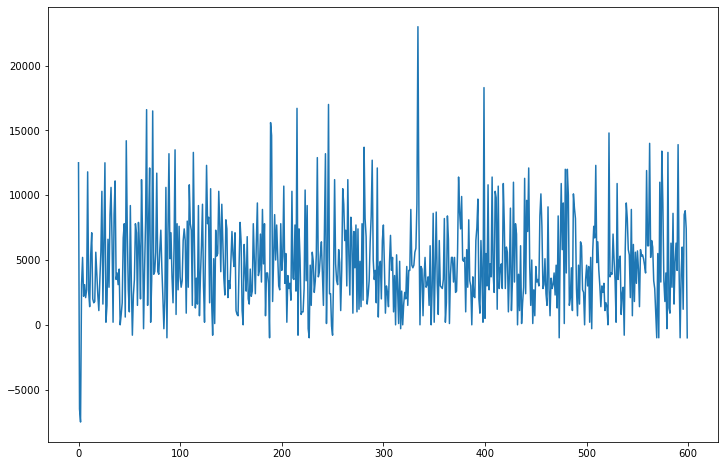

In [25]:
plot(agent_results[0])